## FB15k-237 semantic graph

https://www.kaggle.com/datasets/latebloomer/fb15k-237/data

https://www.kaggle.com/datasets/latebloomer/freebase-wikidata-mapping

In [ ]:
!pip install kagglehub

In [ ]:
import kagglehub

# path = kagglehub.dataset_download("latebloomer/fb15k-237")
# print("Path to dataset files:", path)

In [165]:
import pandas as pd
import numpy as np

In [2]:
data_path = "../datasets/fb15k-237/"

### Load triples and augment from source

In [169]:
column_names = ['src_freebase_id', 'relation', 'dest_freebase_id']
triples_df = pd.read_csv(f"{data_path}/train.txt", header=None, names=column_names)
# df = pd.read_csv(f"{data_path}/train.txt", sep='/t', header=None, names=column_names)

In [170]:
triples_df['triple_id'] = triples_df.index

In [171]:
triples_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272115 entries, 0 to 272114
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   src_freebase_id   272115 non-null  object
 1   relation          272115 non-null  object
 2   dest_freebase_id  272115 non-null  object
 3   triple_id         272115 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 8.3+ MB


In [172]:
triples_df.head(5)

,src_freebase_id,relation,dest_freebase_id,triple_id
0,/m/027rn,/location/country/form_of_government,/m/06cx9,0
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0,1
2,/m/07s9rl0,/media_common/netflix_genre/titles,/m/0170z3,2
3,/m/01sl1q,/award/award_winner/awards_won./award/award_ho...,/m/044mz_,3
4,/m/0cnk2q,/soccer/football_team/current_roster./sports/s...,/m/02nzb8,4


In [173]:
triples_df[['src_freebase_id', 'dest_freebase_id']].describe()

,src_freebase_id,dest_freebase_id
count,272115,272115
unique,13781,13379
top,/m/09c7w0,/m/09c7w0
freq,1325,6289


In [174]:
triples_df[['relation']].describe()

,relation
count,272115
unique,237
top,/award/award_nominee/award_nominations./award/...
freq,15989


In [175]:
# triples_df[['relation']].value_counts()

In [176]:
# triples_df['relation'] = triples_df['relation'].astype('category')

In [177]:
# add random timestamps to force fit into KumoAI restrictions
base_date = pd.Timestamp('2025-01-01')

num_triples = len(triples_df)
random_days_ago_integers = np.random.randint(1, 90, size=num_triples)

time_deltas = pd.to_timedelta(random_days_ago_integers, unit='days')

triples_df['timestamp'] = base_date - time_deltas

### Load augmented triples directly

In [205]:
# triples_df.to_csv(f"{data_path}/derived/fb_train_triples.csv", index=False)
triples_df = pd.read_csv(f"{data_path}/derived/fb_train_triples.csv")

In [178]:
relations_observed = triples_df['relation'].unique()

In [179]:
relations_df = pd.DataFrame(relations_observed, columns=['relation_name'])
relations_df['relation_id'] = relations_df.index

In [180]:
# relations_df['relation_name'] = relations_df['relation_name'].astype('category')
relations_df['relation_name'] = relations_df['relation_name'].astype('object')

,relation_name,relation_id
0,/location/country/form_of_government,0
1,/tv/tv_program/regular_cast./tv/regular_tv_app...,1
2,/media_common/netflix_genre/titles,2
3,/award/award_winner/awards_won./award/award_ho...,3
4,/soccer/football_team/current_roster./sports/s...,4


In [208]:
# relations_df.to_csv(f"{data_path}/derived/relations_with_ids.csv", index=False)
relations_df = pd.read_csv(f"{data_path}/derived/relations_with_ids.csv")

In [209]:
relations_df.head()

,relation_name,relation_id
0,/location/country/form_of_government,0
1,/tv/tv_program/regular_cast./tv/regular_tv_app...,1
2,/media_common/netflix_genre/titles,2
3,/award/award_winner/awards_won./award/award_ho...,3
4,/soccer/football_team/current_roster./sports/s...,4


In [182]:
triples_use_relation_id_df =  pd.merge(triples_df, relations_df, left_on ='relation', right_on='relation_name')
# triples_use_relation_id_df.head()

In [11]:
freebase_vs_wiki_df =  pd.read_csv(f"{data_path}/fb_wiki_mapping.tsv", sep='\t')
# freebase_vs_wiki_df =  pd.read_csv(f"{data_path}/fb_wiki_mapping.csv")

In [12]:
# freebase_vs_wiki_df[''] = df.index
freebase_vs_wiki_df.head(3)

,freebase_id,wikidata_id,label
0,/m/010005,Q974334,Corinth
1,/m/01000j,Q981582,Draper
2,/m/01000w,Q977417,Cross Roads


In [13]:
freebase_vs_wiki_df.describe()

,freebase_id,wikidata_id,label
count,2096636,2096636,2095837
unique,2094552,2096636,1959699
top,/m/060gfy,Q974334,Central District
freq,3,1,373


In [14]:
# strip Q from wikidata id for easier use with Kumo AI
freebase_vs_wiki_df['wikidata_int_id'] = freebase_vs_wiki_df.apply(lambda row: int(row['wikidata_id'][1:]), axis=1)

In [15]:
freebase_vs_wiki_df.drop('wikidata_id', axis=1, inplace=True)
freebase_vs_wiki_df.rename(columns={'wikidata_int_id':'wikidata_id'}, inplace=True)

In [183]:
# are there any in the join
triplets_with_src_wiki_ids_df = pd.merge(triples_use_relation_id_df, freebase_vs_wiki_df, left_on='src_freebase_id', right_on='freebase_id')

In [184]:
# triplets_with_src_wiki_ids_df.info()

In [185]:
triplets_with_src_dst_wiki_ids_df = pd.merge(triplets_with_src_wiki_ids_df, freebase_vs_wiki_df, left_on='dest_freebase_id', right_on='freebase_id')

In [186]:
triplets_with_src_dst_wiki_ids_df.head(3)

,src_freebase_id,relation,dest_freebase_id,triple_id,timestamp,relation_name,relation_id,freebase_id_x,label_x,wikidata_id_x,freebase_id_y,label_y,wikidata_id_y
0,/m/027rn,/location/country/form_of_government,/m/06cx9,0,2024-10-06,/location/country/form_of_government,0,/m/027rn,Dominican Republic,786,/m/06cx9,republic,7270
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0,1,2024-11-05,/tv/tv_program/regular_cast./tv/regular_tv_app...,1,/m/017dcd,Mighty Morphin Power Rangers,513809,/m/06v8s0,Wendee Lee,2642437
2,/m/07s9rl0,/media_common/netflix_genre/titles,/m/0170z3,2,2024-12-08,/media_common/netflix_genre/titles,2,/m/07s9rl0,drama film,130232,/m/0170z3,American History X,208572


In [187]:
triplets_with_src_dst_wiki_ids_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243636 entries, 0 to 243635
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   src_freebase_id   243636 non-null  object        
 1   relation          243636 non-null  object        
 2   dest_freebase_id  243636 non-null  object        
 3   triple_id         243636 non-null  int64         
 4   timestamp         243636 non-null  datetime64[ns]
 5   relation_name     243636 non-null  object        
 6   relation_id       243636 non-null  int64         
 7   freebase_id_x     243636 non-null  object        
 8   label_x           243636 non-null  object        
 9   wikidata_id_x     243636 non-null  int64         
 10  freebase_id_y     243636 non-null  object        
 11  label_y           243636 non-null  object        
 12  wikidata_id_y     243636 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(8)
memory usage: 24.

In [188]:
triplets_with_src_dst_wiki_ids_df.rename(columns={'wikidata_id_x':'src_wikidata_id', 'wikidata_id_y':'dest_wikidata_id'}, inplace=True)

In [210]:
# triplets_with_src_dst_wiki_ids_df.to_csv(f"{data_path}/derived/triplets_with_src_dst_wiki_ids.csv", index=False)
triplets_with_src_dst_wiki_ids_df = pd.read_csv(f"{data_path}/derived/triplets_with_src_dst_wiki_ids.csv")

In [22]:
# All nodes and associated triples for freebase / wiki ?
import kumoai as kumo

In [24]:
import kumoai.experimental.rfm as rfm
import os

In [26]:
if not os.environ.get("KUMO_API_KEY"):
    rfm.authenticate()

Opening browser page to automatically generate an API key...


[2025-08-17 19:35:40 - kumoai:298 - INFO] Generated token "sdk-macbook-pro-3.local-2025-08-17-19-35-38-Z" and saved to KUMO_API_KEY env variable


In [27]:
KUMO_API_KEY = os.environ.get("KUMO_API_KEY")
rfm.init(api_key=KUMO_API_KEY)

[2025-08-17 19:35:49 - kumoai:196 - INFO] Successfully initialized the Kumo SDK against deployment https://kumorfm.ai/api, with log level INFO.


In [189]:
triples = rfm.LocalTable(
    triplets_with_src_dst_wiki_ids_df[['triple_id', 'src_wikidata_id', 'relation_id', 'dest_wikidata_id', 'timestamp']], 
    name="triples"
).infer_metadata()

Detected primary key 'triple_id' and time column 'timestamp' in table 'triples'


In [121]:
relations = rfm.LocalTable(
    relations_df, name="relations", primary_key='relation_id'
).infer_metadata()

In [29]:
freebase_vs_wiki = rfm.LocalTable(freebase_vs_wiki_df, name="freebase_vs_wiki", primary_key="wikidata_id").infer_metadata()

In [190]:
graph = rfm.LocalGraph(tables=[
    triples,
    relations,
    freebase_vs_wiki,
])

In [191]:
# graph.link(src_table="freebase_vs_wiki", fkey="src_wikidata_id", dst_table="triples")
graph.link(src_table="triples", fkey="src_wikidata_id", dst_table="freebase_vs_wiki")

LocalGraph(
  tables=[triples, relations, freebase_vs_wiki],
  edges=[Edge(src_table='triples', fkey='src_wikidata_id', dst_table='freebase_vs_wiki')],
)

In [192]:
graph.link(src_table="triples",fkey="relation_id", dst_table="relations")
# graph.link(src_table="triples", fkey="dest_wikidata_id", dst_table="freebase_vs_wiki")

LocalGraph(
  tables=[triples, relations, freebase_vs_wiki],
  edges=[Edge(src_table='triples', fkey='src_wikidata_id', dst_table='freebase_vs_wiki'), Edge(src_table='triples', fkey='relation_id', dst_table='relations')],
)

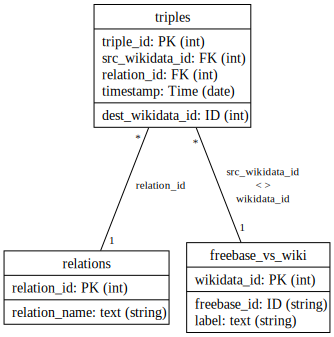

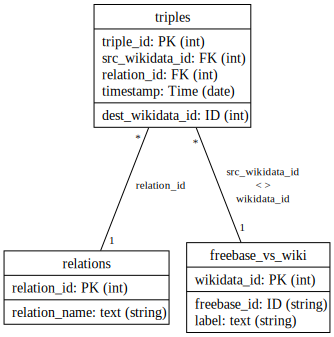

In [193]:
graph.visualize()

In [81]:
# graph['triples']['relation'].stype
# graph['triples']['relation_id'].stype

In [194]:
model = rfm.KumoRFM(graph)

Output()

In [56]:
# PREDICT triples.relation
# Couldn't pick a unique triples.relation for each freebase_vs_wiki. row 1, column 8: Encountered an error, we have found 
# multiple 'relation' values in the 'triples' table for a single 'freebase_vs_wiki'. To fix this, you have two options:
## 1. Aggregate the values: If your 'triples' table has a 'created at' column, use an aggregation function to reduce them to one value. 
##   For example: PREDICT LAST(triples.relation, 0, 30, days).
## 2. Rewrite your query: If you are writing a static node prediction predictive query, make sure that you 
##   either use the same table to define your target and entity, or you have a foreign key from the entity pointing to the target table, 
##   not the other way around.

# PREDICT triples.relation RANK TOP 10
## Problem type 'ProblemType.RANK' is only supported for multicategorical targets. . row 1, column 8: Target 'triples.relation' is 
## not multicategorical. Either drop the problem type ProblemType.RANK OR 
## change the target to a multicategorical column, 'LAST'/'FIRST' aggregation of a multicategorical column, or a 'LIST_DISTINCT' aggregation.

# FOR triples.src_wikidata_id=7413907
# Invalid entity. row 2, column 4: Entity 'triples.src_wikidata_id' is not a primary key. 
# The column used in 'FOR EACH' has to be a primary key.

# FOR 

# WHERE triples.relation contains 'place'


In [ ]:
# kumo.init(api_key=KUMO_API_KEY)

In [ ]:
# Working queries

query = """
PREDICT freebase_vs_wiki.freebase_id 
FOR freebase_vs_wiki.wikidata_id=7413907 
"""

query = """
PREDICT LIST_DISTINCT(triples.relation_id, 0, 80, days)
FOR freebase_vs_wiki.wikidata_id=486860 
"""


In [211]:

query = """
PREDICT LIST_DISTINCT(triples.relation_id, 0, 80, days)
FOR freebase_vs_wiki.wikidata_id=2685 
"""
# WHERE triples.relation_id = 111

df = model.predict(query)
display(df)

/Users/ravid/miniconda3/envs/kumo-hackathon-py311/lib/python3.11/site-packages/kumoai/experimental/rfm/rfm.py:360: 
UserWarning: Anchor timestamp is too early or aggregation time range is too large. To form proper input data, we 
would need data back to '2024-07-24 00:00:00', however, your data only contains data back to '2024-10-04 00:00:00'.
  warnings.warn(f"Anchor timestamp is too early or aggregation "

Output()

,ENTITY,ANCHOR_TIMESTAMP,CLASS,SCORE
0,2685,2024-12-31T00:00:00,6,0.960215
1,2685,2024-12-31T00:00:00,38,0.955566
2,2685,2024-12-31T00:00:00,19,0.950369
3,2685,2024-12-31T00:00:00,45,0.914983
4,2685,2024-12-31T00:00:00,17,0.761230
5,2685,2024-12-31T00:00:00,66,0.659995
6,2685,2024-12-31T00:00:00,77,0.647791
7,2685,2024-12-31T00:00:00,164,0.646484
8,2685,2024-12-31T00:00:00,179,0.646484
9,2685,2024-12-31T00:00:00,100,0.643066


pquery_relations_for_entity = kumo.PredictiveQuery(
	graph=graph,
	query=query
)

pquery_relations_for_entity.validate()

In [112]:
graph._to_api_graph_definition()

GraphDefinition(tables={'relations': TableDefinition(cols=[Column(name='relation_name', stype=text, dtype=string, timestamp_format=None), Column(name='relation_id', stype=ID, dtype=int, timestamp_format=None)], source_table=UnavailableSourceTable(table='relations', data_source_type=UNAVAILABLE), pkey='relation_id', time_col=None, end_time_col=None)}, col_groups=[])

In [145]:
# Running examples
# all relations with src_wikidata_id 
## 7413907 / Q7413907 , San Francisco
## 486860 , Mountain View
## 2685, Arnold Schwarzenegger


triplets_with_src_dst_wiki_ids_df.loc[triplets_with_src_dst_wiki_ids_df['src_wikidata_id']==2685].to_csv(
    "~/Downloads/arnold_schwarzenegger_outgoing_edges.csv", index=False
)
# 7413907]


In [ ]:
## Arnold Schwarznegger

# 6 -> /film/actor/film./film/performance/film
# 38 -> nomination
# 

In [159]:
df44 = triplets_with_src_dst_wiki_ids_df[['src_freebase_id', 'src_wikidata_id', 'label_x']].drop_duplicates()
# df44.to_csv('~/Downloads/triples_train_src_entities.csv', index=False)

## Yago semantic graph 
Usecase - find inconsistencies / anomalies in knowledge graphs